In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm
import pickle
import seaborn as sns
import multiprocessing
import re
from importlib import reload

In [2]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/cper_hls_veg_models/biomass/params')
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/fit')
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/extract')

In [45]:
reload(sys.modules["cper_bm_params_fit_kmeans_transect"])
from cper_bm_params_fit_kmeans_transect import *

In [36]:
#reload(sys.modules["hpc_setup"])
from hpc_setup import launch_dask
from ml_setup import fit_ols, fit_dnn

In [37]:
#client.cluster.close()
#client.close()

In [6]:
if backend == 'dask':
    from hpc_setup import launch_dask
    import psutil
    interface_prefs = [
        'ibp175s0',
        'ibp59s0',
        'enp24s0f0',
        'ens7f0',
        'ibp24s0',
        'ib0'
    ]
    interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
    if len(interface) == 0:
        print('ERROR: Preferred interfaces not found on node!')
    else:
        print(interface)
    num_jobs=32
    client = launch_dask(cluster_loc=cluster_loc,
                         num_jobs=num_jobs,
                         mem_gb_per=4.0,
                         partition='atlas', 
                         duration='04:00:00',
                         slurm_opts={'interface': interface},
                          extra_directives=["--account=cper_neon_aop"],
                        wait_timeout=300,
                        debug=False)
    display(client)
    nthreads = len(client.nthreads())
else:
    nthreads = multiprocessing.cpu_count()

ib0
   setting up cluster on HPC...


<Client: 'tcp://172.21.15.46:46635' processes=0 threads=0, memory=0 B>

In [38]:
import torch
if torch.has_cuda and use_cuda:
    device='cuda'
    print(torch.cuda.device_count())
else:
    device='cpu'
print(device)

cpu


In [39]:
#reload(sys.modules["ml_setup"])
from ml_setup import make_model_dictionary
from ml_setup import run_ml_models

In [40]:
import random
import re

In [50]:
keep_fracs = [100, 99, 95, 85, 75, 50, 10, 1]
rand_seeds = list(np.arange(120, 128))

In [51]:
for idx_d, keep_frac in enumerate(keep_fracs):
    reload(sys.modules["cper_bm_params_fit_kmeans_transect"])
    from cper_bm_params_fit_kmeans_transect import *
    mod_dict = make_model_dictionary(var_names, y_col, device)
    df = load_df(inPATH, ['Date', 'Date_mean'])
    df = df.reset_index(drop=True)
    if keep_frac != 100:
        print('Running using Kmeans clusters resampled with random proportion after keeping ' + str(keep_frac))
        kfold_group = kfold_group + '_r' + str(keep_frac)
        tuneby_group = tuneby_group + '_r' + str(keep_frac)

        outFILE_tmp = os.path.join(outDIR, 'tmp', re.sub('hls_idxs.csv', 'cv_' + kfold_group + '_tuneby_' + tuneby_group + '_tmp.csv', inFILE))
        
        df[kfold_group] = ''
        random.seed(rand_seeds[idx_d].item())
        test = df.groupby(['Plot', 'Date_mean']).first().reset_index().groupby(kfold_group).sample(frac=(100-keep_frac)*0.01)
        samp = df[df['Plot'].str.cat(df['Date_mean'].astype(str), sep='_').isin(
            test['Plot'].str.cat(test['Date_mean'].astype(str), sep='_'))][kfold_group]
        random.seed(rand_seeds[idx_d].item())
        df.loc[samp.index, kfold_group] = np.random.randint(0, len(df[kfold_group].unique()), len(samp)).astype(str)
        df.loc[[x for x in df.index if x not in samp.index], kfold_group] = df.loc[[x for x in df.index if x not in samp.index], 'Kmeans']
        df['Kmeans_keepfrac'] = keep_frac
    else:
        print('Running using Kmeans clusters')
    
    mod_dict['DNN']['fit'] = False
    if prefix == 'transect':
        mod_dict['DNN']['param_grid']['batch_size'] =  [256]
    
    if 'BAI_236' not in var_names or 'NDII7' not in var_names or 'NIR1' not in var_names:
        mod_dict['CPER_2022']['fit'] = False
        mod_dict['OLS_2022']['fit'] = False
    
    #for k in mod_dict.keys():
    #    if k not in ['SVR', 'HGBR']:
    #        mod_dict[k]['fit'] = False
    
    mod_dict['GBR']['fit'] = False
    mod_dict['HGBR']['variable_importance'] = True
    
    run_ml_models(nickname,
                 mod_dict,
                 df, 
                 y_col,
                 date_col,
                 var_names,
                 kfold_group,
                 tuneby_group, 
                 kfold_type,
                 tune_kfold_type,
                 outFILE_tmp, 
                 outDIR,
                 backend,
                 nthreads,
                 cper_mod_xfrm,
                 cper_mod_xfrm_func,
                 client)

Running using Kmeans clusters
Output file already exists. Loading saved dataset.
0
Skipping CPER_2022, data already in saved dataframe.
Skipping OLS_2022, data already in saved dataframe.
Skipping OLS, data already in saved dataframe.
Skipping LASSO, data already in saved dataframe.
Skipping PLS, data already in saved dataframe.
Skipping PCR, data already in saved dataframe.
Skipping SVR, data already in saved dataframe.
Skipping RF, data already in saved dataframe.
Skipping GBR, params not set to fit.
Skipping HGBR, data already in saved dataframe.
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
1
Skipping CPER_2022, data already in saved dataframe.
Skipping OLS_2022, data already in saved dataframe.
Skipping OLS, data already in saved dataframe.
Skipping LASSO, data already in saved dataframe.
Skipping PLS, data already in saved dataframe.
Skipping PCR, data already in saved dataframe.
Skipping SVR, data already in saved dataframe.
Skipping RF, data already 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:585: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])


(time to fit: 10.82 secs)
....fitting LASSO 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:671: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.55 secs)
....fitting PLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:692: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.31 secs)
....fitting PCR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:703: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 1.22 secs)
....fitting SVR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:708: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.23 secs)
....fitting RF 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:714: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 2.45 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 3.92 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
1
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 13.46 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 30.34 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 30.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.451e+04, tolerance: 7.647e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 14.24 secs)
....fitting PLS (time to fit: 0.4 secs)
....fitting PCR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:703: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.53 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.23 secs)
....fitting RF (time to fit: 28.38 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 4.89 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
2
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 12.48 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 30.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 30.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 10.65 secs)
....fitting PLS (time to fit: 0.48 secs)
....fitting PCR (time to fit: 0.55 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 2.95 secs)
....fitting RF (time to fit: 32.85 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 4.78 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
3
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.28 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 30.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 30.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.240e+02, tolerance: 7.642e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 13.23 secs)
....fitting PLS (time to fit: 0.38 secs)
....fitting PCR (time to fit: 0.55 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.4 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 11.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 26.83 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 6.46 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
4
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.05 secs)
....fitting OLS (time to fit: 12.48 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 30.34 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 30.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 9.46 secs)
....fitting PLS (time to fit: 0.45 secs)
....fitting PCR (time to fit: 0.46 secs)
....fitting SVR (time to fit: 2.25 secs)
....fitting RF (time to fit: 33.86 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 4.64 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.


In [26]:
reload(sys.modules["cper_bm_params_fit_kmeans_transect"])
from cper_bm_params_fit_kmeans_transect import *

In [27]:
keep_frac = 75
idx_d = 4
reload(sys.modules["cper_bm_params_fit_kmeans_transect"])
from cper_bm_params_fit_kmeans_transect import *
mod_dict = make_model_dictionary(var_names, y_col, device)
df = load_df(inPATH, ['Date', 'Date_mean'])
df = df.reset_index(drop=True)
if keep_frac != 100:
    print('Running using Kmeans clusters resampled with random distance factor of ' + str(keep_frac))
    kfold_group = kfold_group + '_r' + str(keep_frac)
    tuneby_group = tuneby_group + '_r' + str(keep_frac)

    outFILE_tmp = os.path.join(outDIR, 'tmp', re.sub('hls_idxs.csv', 'cv_' + kfold_group + '_tuneby_' + tuneby_group + '_tmp.csv', inFILE))
    
    df[kfold_group] = ''
    random.seed(rand_seeds[idx_d].item())
    test = df.groupby(['Plot', 'Date_mean']).first().reset_index().groupby(kfold_group).sample(frac=(100-keep_frac)*0.01)
    samp = df[df['Plot'].str.cat(df['Date_mean'].astype(str), sep='_').isin(
        test['Plot'].str.cat(test['Date_mean'].astype(str), sep='_'))][kfold_group]
    random.seed(rand_seeds[idx_d].item())
    df.loc[samp.index, kfold_group] = np.random.randint(0, 10, len(samp)).astype(str)
    df.loc[[x for x in df.index if x not in samp.index], kfold_group] = df.loc[[x for x in df.index if x not in samp.index], 'Kmeans']
    df['Kmeans_keepfrac'] = keep_frac
else:
    print('Running using Kmeans clusters')

mod_dict['DNN']['fit'] = False
if prefix == 'transect':
    mod_dict['DNN']['param_grid']['batch_size'] =  [256]

if 'BAI_236' not in var_names or 'NDII7' not in var_names or 'NIR1' not in var_names:
    mod_dict['CPER_2022']['fit'] = False
    mod_dict['OLS_2022']['fit'] = False

#for k in mod_dict.keys():
#    if k not in ['SVR', 'HGBR']:
#        mod_dict[k]['fit'] = False

mod_dict['GBR']['fit'] = False
mod_dict['HGBR']['variable_importance'] = True

Running using Kmeans clusters resampled with random distance factor of 75


In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import re

In [30]:
#https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl

In [31]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [32]:
def plot_pcs(df, ax, var_names, pc_type, var_reduce_type, k, vars_of_interest, title=None, n_comps=None, n_std=2.0, pcs=[1,2], topk=2):    
    # load data
    X = df[var_names]
    y = df['sqrt_Biomass_kg_ha']
    features = var_names
    X_scaled = StandardScaler().fit_transform(X)
    if n_comps is None:
        n_comps = len(var_names)
    pcs_idx = [i-1 for i in pcs]
    if pc_type == 'pca':
        features +=  ['sqrt_Biomass_kg_ha']
        # analysis
        pca = PCA(n_components=10).fit(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        X_reduced = pca.transform(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        # results
        scores = X_reduced[:, pcs_idx]
        loadings = pca.components_[pcs_idx].T
        pvars = pca.explained_variance_ratio_[pcs_idx] * 100
    elif pc_type == 'pls':
        pls2 = PLSRegression(n_components=n_comps)
        pls2.fit(X_scaled, y)
        loadings = pls2.x_loadings_[:,pcs_idx]
        scores = pls2.x_scores_[:, pcs_idx]
        naY = y
        r2_scores = []
        for i in range(0,n_comps):
            Y_pred=np.dot(pls2.x_scores_[:,i].reshape(-1,1),pls2.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y,Y_pred),3))
        pvars = np.array(r2_scores)[pcs_idx]*100
    
    if var_reduce_type == 'top_k':
        tops = (loadings ** 2).sum(axis=1).argsort()[-topk:]
    elif var_reduce_type == 'manual':
        tops = [i for i, value in enumerate(features) if value in vars_of_interest]
    
    if pc_type == 'pca':
        tops = [x for x in tops if (x+1) != len(features)]
    arrows = loadings[tops]
    arrows /= np.sqrt((arrows ** 2).sum(axis=0))
    arrows *= np.abs(scores).max(axis=0)
    
    if pc_type == 'pca':
        bm_arrow = loadings[-1]
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
    elif pc_type == 'pls':
        bm_arrow = pls2.y_loadings_[:,pcs_idx].squeeze()
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
        #bm_arrow *= np.abs(pls2.y_scores_).max(axis=0)
    
    for idx, i in enumerate(pcs):
        df['PC'+str(i)] = scores[:,idx]
    
    #plt.scatter(scores[:, 0], scores[:,1], s=8, alpha=0.5)
    sns.scatterplot(x='PC'+str(pcs[0]), y='PC'+str(pcs[1]), data=df, hue='Season',
                    edgecolor='none', alpha=0.3, s=6, palette='Greys', ax=ax)
    #ax.legend(title=None, loc='lower center', ncols=5)
    width = -0.005 * np.min([np.subtract(*ax.get_xlim()), np.subtract(*ax.get_ylim())])
    for i, arrow in zip(tops, arrows):
        ax.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
        ax.text(*(arrow * 1.3), features[i], ha='center', va='center', color='k')
    ax.arrow(0, 0, *bm_arrow, color='grey', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
    ax.text(*(bm_arrow * 1.2), 'Biomass', ha='center', va='center', color='grey')

    ax.set_xlim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    ax.set_ylim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    
    for idx, axis in enumerate('xy'):
        #getattr(plt, f'{axis}ticks')([])
        getattr(ax, f'set_{axis}label')(f'PC{pcs[idx]} ({pvars[idx]:.2f}%)')
    custom_lines = []
    kfold_labels = []
    for i, k in enumerate(df['kfold'].sort_values().unique()):
        custom_lines.append(Line2D([0], [0], 
                                   color=mpl.colormaps['tab10'].colors[i],
                                   lw=3))
        confidence_ellipse(df['PC'+str(pcs[0])][df['kfold'] == k], 
                           df['PC'+str(pcs[1])][df['kfold'] == k], 
                           ax,
                           edgecolor=mpl.colormaps['tab10'].colors[i],
                           n_std=n_std)
        if type(k) == np.float_:
            kfold_labels.append(str(int(k)))
        elif 'kfold' in k:
            kfold_labels.append(re.sub('kfold', '', k))
        else:
            kfold_labels.append(str(k))
    ax.legend(custom_lines, kfold_labels, frameon=False)
    ax.set_title(title, y=1.0)
    return ax

In [33]:
#df['kfold'] = df[kfold_group]
df['kfold'] = df['Kmeans']

(-13.0, 13.0)

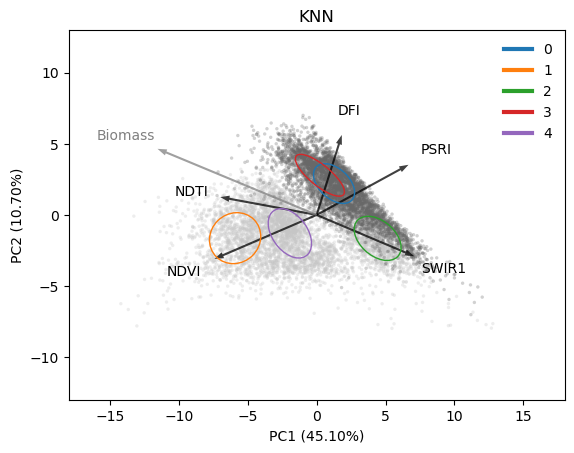

In [34]:
fig, ax = plt.subplots()
plot_pcs(df=df,
         ax=ax,
         var_names=var_names,
         pc_type = 'pls',
         var_reduce_type = 'manual',
         k=None,
         vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
         #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
         title='KNN',
         n_std=1.0,
         pcs=[1,2])
ax.set_xlim((-18, 18))
ax.set_ylim((-13, 13))